In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

import pdb
from tqdm import tqdm

from torchsummary import summary

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torchType = torch.float32

In [3]:
def true_f(x):
    return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    Y = true_f(X) + np.random.normal(0, 0.1, n)

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

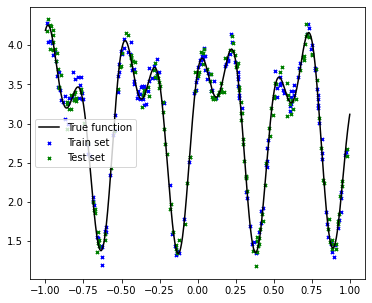

In [4]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x)

X_train, y_train, X_test, y_test = get_data(200, 200)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [5]:
class NetReg(nn.Module):
    def __init__(self, n_hidden=10):
        super().__init__()
        self.n_hidden = n_hidden
        self.linear1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)

    def forward(self, x):
        h1 = torch.relu(self.linear1(x))
        h2 = torch.relu(self.linear2(h1))
        return h2

In [6]:
n_hidden = 50

model_reg = NetReg(n_hidden=n_hidden).to(device)

last_weight_mu = nn.Parameter(torch.randn((n_hidden, 2), device=device, dtype=torchType))
last_weight_logvar = nn.Parameter(torch.randn((n_hidden, 2), device=device, dtype=torchType))

last_bias_mu = nn.Parameter(torch.randn((1, 2), device=device, dtype=torchType))
last_bias_logvar = nn.Parameter(torch.randn((1, 2), device=device, dtype=torchType))

params_reg = list(model_reg.parameters()) + [last_weight_mu, last_weight_logvar] + [last_bias_mu, last_bias_logvar]
optimizer_reg = torch.optim.Adam(params_reg)

# Noise generator
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torchType),
                                       scale=torch.tensor(1., device=device, dtype=torchType),)

X_train_tensor = torch.from_numpy(X_train.reshape((-1, 1))).float().to(device)
y_train_tensor = torch.from_numpy(y_train.reshape((-1, 1))).float().to(device)

X_test_tensor = torch.from_numpy(X_test.reshape((-1, 1))).float().to(device)
y_test_tensor = torch.from_numpy(y_test.reshape((-1, 1))).float().to(device)

loss_fn = nn.MSELoss()

In [7]:
num_epoches = 1000

for ep in tqdm(range(num_epoches)):
    for x_train, y_train_labels in [(X_train_tensor, y_train_tensor)]:
        emb = model_reg(x_train)
        last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
        last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)

        outputs = emb @ last_weight + last_bias

        out_mu = outputs[:, 0]
        out_sigma = torch.nn.functional.softplus(outputs[:, 1])

        log_likelihood = torch.distributions.Normal(loc=out_mu, scale=out_sigma).log_prob(y_train_labels).sum()

        KL = (0.5 * (last_weight_logvar + torch.exp(last_weight_logvar) + last_weight_mu ** 2 - 1.)).mean() \
                        + (0.5 * (last_bias_logvar + torch.exp(last_bias_logvar) + last_bias_mu ** 2 - 1.)).mean()

        elbo = log_likelihood - KL
        (-elbo).backward()

        optimizer_reg.step()
        optimizer_reg.zero_grad()

    if ep % 10 == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')

        with torch.no_grad():
            emb = model_reg(X_test_tensor)
            last_weight = last_weight_mu
            last_bias = last_bias_mu
            outs = emb @ last_weight + last_bias
            y_pred = outs[0]
            mse = loss_fn(y_pred, y_test_tensor).to(torchType).cpu().mean().numpy()

        print(f"Mean squared error at epoch number {ep} is {mse}")


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Alex\anaconda3\envs\bayesnn\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([200, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [00:16<00:00, 60.44it/s]


ELBO value is -102693.5859375 on epoch number 0
Mean squared error at epoch number 0 is 1.3713555335998535
ELBO value is -92408.0625 on epoch number 10
Mean squared error at epoch number 10 is 1.0516809225082397
ELBO value is -288043.1875 on epoch number 20
Mean squared error at epoch number 20 is 0.9427682161331177
ELBO value is -65133.0859375 on epoch number 30
Mean squared error at epoch number 30 is 0.8618417382240295
ELBO value is -81818.296875 on epoch number 40
Mean squared error at epoch number 40 is 0.8848435878753662
ELBO value is -92355.296875 on epoch number 50
Mean squared error at epoch number 50 is 0.9398280382156372
ELBO value is -99094.78125 on epoch number 60
Mean squared error at epoch number 60 is 0.9891440868377686
ELBO value is -92782.09375 on epoch number 70
Mean squared error at epoch number 70 is 1.1640918254852295
ELBO value is -89508.2578125 on epoch number 80
Mean squared error at epoch number 80 is 1.271755337715149
ELBO value is -84090.6171875 on epoch num

In [8]:
n_samples = 100

emb = model_reg(X_test_tensor)

samples_m = []
samples_s = []
for i in range(n_samples):
    last_weight = last_weight_mu + std_normal.sample(last_weight_mu.shape) * torch.exp(0.5 * last_weight_logvar)
    last_bias = last_bias_mu + std_normal.sample(last_bias_mu.shape) * torch.exp(0.5 * last_bias_logvar)

    outputs = emb @ last_weight + last_bias
    np_m = outputs[:, 0].cpu().data.numpy()
    np_s = torch.nn.functional.softplus(outputs[:, 1]).cpu().data.numpy()
    samples_m.append(np_m)
    samples_s.append(np_s)

y_pred = np.array(samples_m).mean(axis=0)
y_err = np.array(samples_m).std(axis=0)
#y_err = 2 * np.array(samples_s).mean(axis=0)

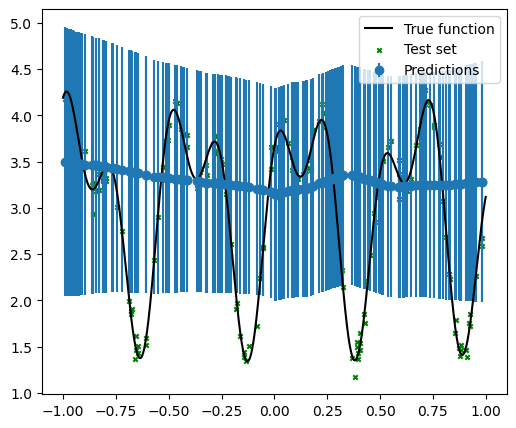

In [9]:
plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=y_err, fmt='o', label='Predictions')

plt.legend()

plt.show()
